In [211]:
from math import ceil
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, \
    f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay
from datetime import datetime

In [212]:
def transform_dataset(dataset: pd.DataFrame):
    df = dataset.copy()
    df['CAN ID'] = df['CAN ID'].apply(lambda i: int(i, 16))
    df['Flag'] = df['Flag'].apply(lambda x: 0 if x == 'R' else 1)

    for i in range(8):
        df[f'DATA{i}'] = df[f'DATA{i}'].apply(lambda i: int(i, 16))

    for col in df.columns:
        df[col] = pd.to_numeric(df[col])
    
    return df

In [213]:
# Training data for baseline model and GridSearch
def splitting_data(dataset: pd.DataFrame):
    data_size = len(dataset)
    train_size = ceil(data_size * .6)
    val_size = ceil((data_size - train_size) * .25)
    # print(train_size, test_size)
    train = dataset.iloc[:train_size]
    vali = dataset.iloc[train_size:train_size+val_size]
    test = dataset.iloc[train_size+val_size:]

    X_train = train.drop(columns=['Flag'])
    y_train = train['Flag']

    X_val = vali.drop(columns=['Flag'])
    y_val = vali['Flag']

    X_test = test.drop(columns=['Flag'])
    y_test = test['Flag']

    return X_train, X_val, X_test, y_train, y_val, y_test

In [214]:
# folder_path = '/Users/gabrielchung/Documents/Data 245/Final Presentation/Car Hacking Dataset/9) Car-Hacking Dataset/{0}_dataset.csv'
folder_path = '/Users/MidAutumnFestival/Documents/DATA-270/datasets/Car Hacking Dataset/dataset/{0}_dataset.csv'
column_names = ['Timestamp', 'CAN ID', 'DLC', 'DATA0', 'DATA1', 'DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7', 'Flag']
attacks = {}
for attack in ['DoS', 'Fuzzy', 'gear', 'RPM']:
    data = pd.read_csv(folder_path.format(attack), names=column_names)
    data = data.dropna()
    attacks[attack] = data

In [215]:
for att, data in attacks.items():
    attacks[att] = transform_dataset(data)

In [216]:
model_data = {
    "X_train": [],
    "X_val": [],
    "X_test": [],
    "y_train": [],
    "y_test": [],
    "y_val": [],
}

for att, data in attacks.items():
    x_tr, x_val, x_te, y_tr, y_val, y_te = splitting_data(data)
    model_data["X_train"].append(x_tr)
    model_data["X_val"].append(x_val)
    model_data["X_test"].append(x_te)
    model_data["y_train"].append(y_tr)
    model_data["y_val"].append(y_val)
    model_data["y_test"].append(y_te)

In [217]:
X_train = pd.concat(model_data["X_train"])
y_train = pd.concat(model_data["y_train"]).values

# For feature selection validation
X_train_pca = X_train.drop(columns=['DLC', 'DATA0', 'DATA1', 'DATA2', 'DATA6'])
X_train_tsvd = X_train.drop(columns=['DLC', 'DATA1', 'DATA2', 'DATA4', 'DATA6'])
X_test_pca = pd.concat(model_data["X_test"]).drop(columns=['DLC', 'DATA0', 'DATA1', 'DATA2', 'DATA6'])
X_test_tsvd = pd.concat(model_data["X_test"]).drop(columns=['DLC', 'DATA1', 'DATA2', 'DATA4', 'DATA6'])
y_test_fe = pd.concat(model_data["y_test"])

X_train = X_train.values
X_train_pca = X_train_pca.values
X_train_tsvd = X_train_tsvd.values
X_test_pca = X_test_pca.values
X_test_tsvd = X_test_tsvd.values
y_test_fe = y_test_fe.values

Baseline model to compare the Features selected by the methods

In [218]:
dtc_pca = DecisionTreeClassifier()
dtc_tsvd = DecisionTreeClassifier()

for fe_type, xtr, xte, model in [('PCA', X_train_pca, X_test_pca, dtc_pca), ('TSVD', X_train_tsvd, X_test_tsvd, dtc_tsvd)]:
    start_time = datetime.now()
    model.fit(xtr, y_train)
    end_time = datetime.now()
    time_diff = end_time - start_time
    print(f"Training time: {time_diff.total_seconds() / 60}")

    y_pred = model.predict(xte)
    print(
        f"""
        {fe_type}
        Accuracy: {accuracy_score(y_test_fe, y_pred)}
        Precision: {precision_score(y_test_fe, y_pred)}
        Recall: {recall_score(y_test_fe, y_pred)}
        F1-Score: {f1_score(y_test_fe, y_pred)}
        ROC AUC: {roc_auc_score(y_test_fe, y_pred)}
        """
    )

Training time: 0.41575626666666665

        PCA
        Accuracy: 0.9994082236548034
        Precision: 1.0
        Recall: 0.9864901302637819
        F1-Score: 0.993199125668737
        ROC AUC: 0.9932450651318909
        
Training time: 0.42426068333333333

        TSVD
        Accuracy: 0.9999930762574891
        Precision: 0.9998930799483065
        Recall: 0.9999488614703722
        F1-Score: 0.9999209699313834
        ROC AUC: 0.9999719816010403
        


TSVD's features performed slightly better. Therefore, we will be using the features selected by TSVD to conduct the evaluation on baseline model, K-fold cross validation and Hyperparameter tuning (Grid Search).

In [219]:
dtc_baseline = dtc_tsvd

X_train = X_train_tsvd
model_data["X_val"] = [ x_val.drop(columns=['DLC', 'DATA1', 'DATA2', 'DATA4', 'DATA6']) for x_val in model_data["X_val"]]
model_data["X_test"] = [ x_test.drop(columns=['DLC', 'DATA1', 'DATA2', 'DATA4', 'DATA6']) for x_test in model_data["X_test"]]
X_val = pd.concat(model_data["X_val"]).values
X_test = pd.concat(model_data["X_test"]).values
model_data["X_val"] = [ x_val.values for x_val in model_data["X_val"]]
model_data["X_test"] = [ x_test.values for x_test in model_data["X_test"]]

y_val = pd.concat(model_data["y_val"]).values
y_test = pd.concat(model_data["y_test"]).values
model_data["y_val"] = [y_val.values for y_val in model_data["y_val"]]
model_data["y_test"] = [y_test.values for y_test in model_data["y_test"]]

In [220]:
# To keep track of the validation training loss using mean squaread error
train_mses = []
val_mses = {
    'DoS': [],
    'Fuzzy': [],
    'gear': [],
    'RPM': [],
}

Baseline model prediction for each attack


    Overall performance
    Accuracy: 0.9999930762574891
    Precision: 0.9998930799483065
    Recall: 0.9999488614703722
    F1-Score: 0.9999209699313834
    ROC AUC: 0.9999719816010403

    


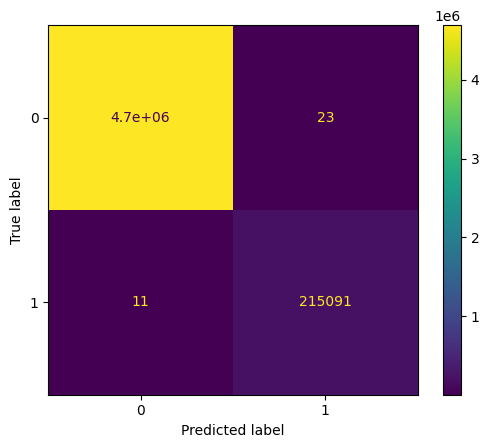

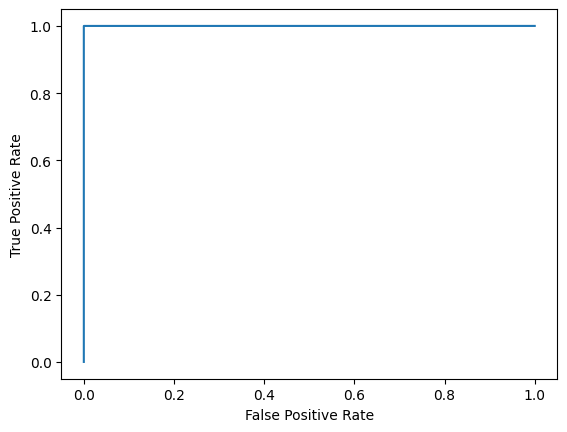

In [221]:
y_train_pred = dtc_baseline.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mses.append(train_mse)

y_pred_base = dtc_baseline.predict(X_test)
print(
    f"""
    Overall performance
    Accuracy: {accuracy_score(y_test, y_pred_base)}
    Precision: {precision_score(y_test, y_pred_base)}
    Recall: {recall_score(y_test, y_pred_base)}
    F1-Score: {f1_score(y_test, y_pred_base)}
    ROC AUC: {roc_auc_score(y_test, y_pred_base)}\n
    """
)
conf_matrix = confusion_matrix(y_test, y_pred_base)
cm_display = ConfusionMatrixDisplay(conf_matrix).plot()
fpr, tpr, _ = roc_curve(y_test, y_pred_base)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()



        Overall performance
        Accuracy: 1.0
        Precision: 1.0
        Recall: 1.0
        F1-Score: 1.0
        ROC AUC: 1.0

        

        Overall performance
        Accuracy: 0.9999893362338778
        Precision: 0.9999760587995882
        Recall: 0.9997367098302975
        F1-Score: 0.9998563699909034
        ROC AUC: 0.9998678934591814

        

        Overall performance
        Accuracy: 1.0
        Precision: 1.0
        Recall: 1.0
        F1-Score: 1.0
        ROC AUC: 1.0

        

        Overall performance
        Accuracy: 0.9999839891359009
        Precision: 0.9997353988261329
        Recall: 1.0
        F1-Score: 0.9998676819073052
        ROC AUC: 0.9999914791102642

        


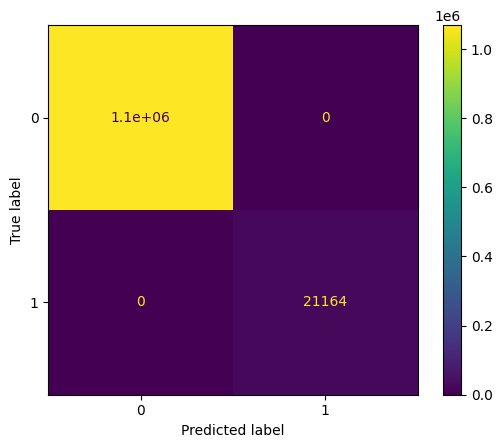

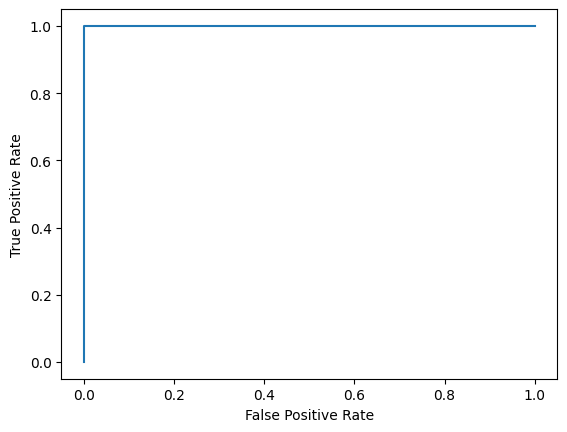

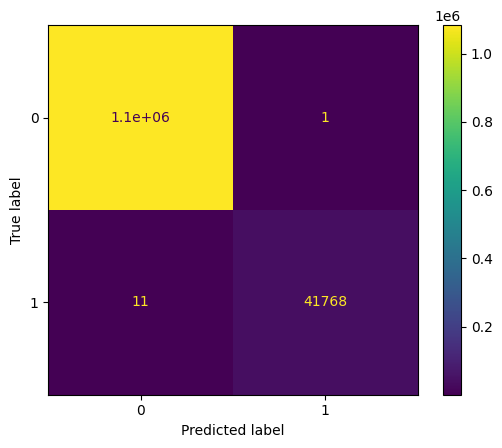

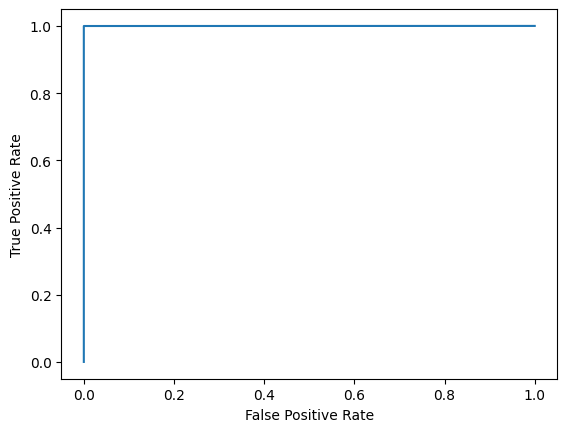

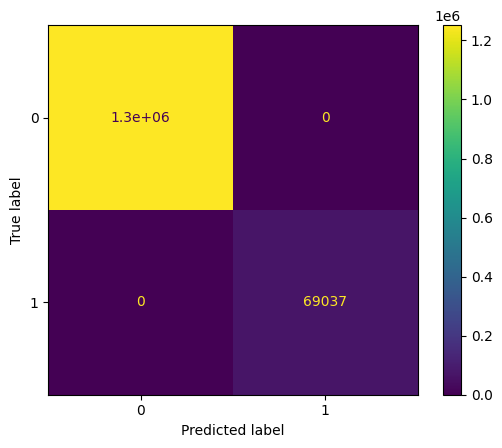

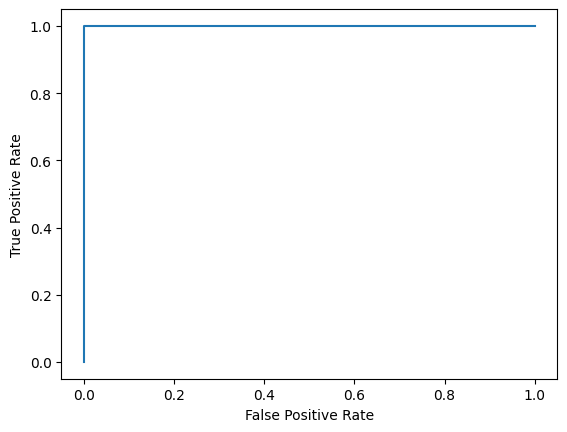

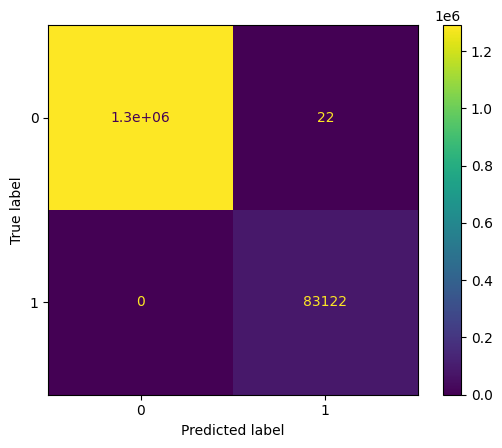

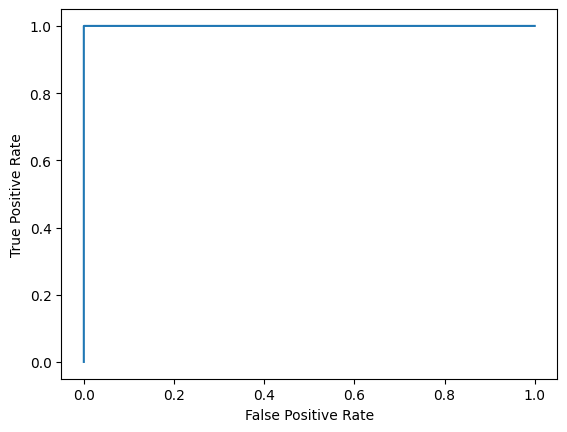

In [222]:
for i, att in enumerate(['DoS', 'Fuzzy', 'gear', 'RPM']):
    y_val_pred = dtc_baseline.predict(model_data["X_val"][i])
    val_mse = mean_squared_error(model_data["y_val"][i], y_val_pred)
    val_mses[att].append(val_mse)


    y_pred_att = dtc_baseline.predict(model_data["X_test"][i])

    print(
        f"""
        Overall performance
        Accuracy: {accuracy_score(model_data["y_test"][i], y_pred_att)}
        Precision: {precision_score(model_data["y_test"][i], y_pred_att)}
        Recall: {recall_score(model_data["y_test"][i], y_pred_att)}
        F1-Score: {f1_score(model_data["y_test"][i], y_pred_att)}
        ROC AUC: {roc_auc_score(model_data["y_test"][i], y_pred_att)}\n
        """
    )
    conf_matrix = confusion_matrix(model_data["y_test"][i], y_pred_att)
    cm_display = ConfusionMatrixDisplay(conf_matrix).plot()
    fpr, tpr, _ = roc_curve(model_data["y_test"][i], y_pred_att)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

K-Fold cross validation

In [223]:
dtc_5_fold = DecisionTreeClassifier()
start_time = datetime.now()
dtc_5_fold = GridSearchCV(dtc_5_fold, param_grid={}, cv=5, scoring='accuracy')
dtc_5_fold.fit(X_train, y_train)
end_time = datetime.now()
time_diff = end_time - start_time
print(f"Training time: {time_diff.total_seconds() / 60}")

Training time: 2.0516624



    Accuracy: 0.999997352686687
    Precision: 1.0
    Recall: 0.9999395635558944
    F1-Score: 0.9999697808647787
    ROC AUC: 0.9999697817779472

    


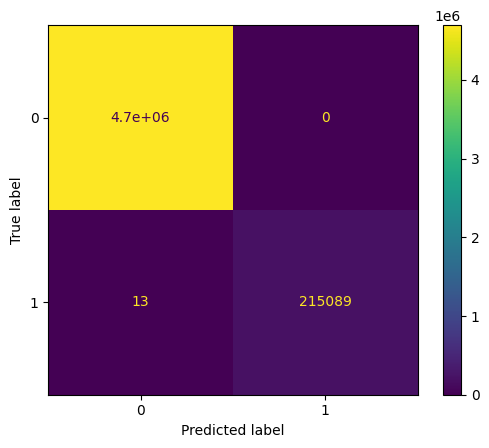

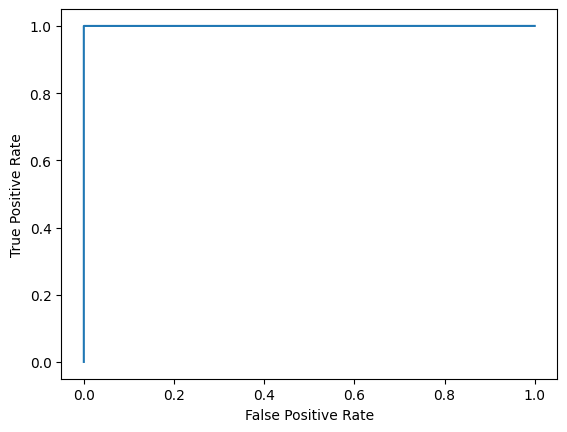

In [224]:
y_pred_k_fold = dtc_5_fold.predict(X_test)
print(
    f"""
    Accuracy: {accuracy_score(y_test, y_pred_k_fold)}
    Precision: {precision_score(y_test, y_pred_k_fold)}
    Recall: {recall_score(y_test, y_pred_k_fold)}
    F1-Score: {f1_score(y_test, y_pred_k_fold)}
    ROC AUC: {roc_auc_score(y_test, y_pred_k_fold)}\n
    """
)
conf_matrix = confusion_matrix(y_test, y_pred_k_fold)
cm_display = ConfusionMatrixDisplay(conf_matrix).plot()
fpr, tpr, _ = roc_curve(y_test, y_pred_k_fold)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [225]:
for i, att in enumerate(['DoS', 'Fuzzy', 'gear', 'RPM']):
    y_pred_att = dtc_5_fold.predict(model_data["X_test"][i])
    print(
        f"""
        {att}
        Accuracy: {accuracy_score(model_data["y_test"][i], y_pred_att)}
        Precision: {precision_score(model_data["y_test"][i], y_pred_att)}
        Recall: {recall_score(model_data["y_test"][i], y_pred_att)}
        F1-Score: {f1_score(model_data["y_test"][i], y_pred_att)}
        ROC AUC: {roc_auc_score(model_data["y_test"][i], y_pred_att)}\n
        """
    )


        DoS
        Accuracy: 1.0
        Precision: 1.0
        Recall: 1.0
        F1-Score: 1.0
        ROC AUC: 1.0

        

        Fuzzy
        Accuracy: 0.9999884475867009
        Precision: 1.0
        Recall: 0.9996888388903516
        F1-Score: 0.9998443952361002
        ROC AUC: 0.9998444194451759

        

        gear
        Accuracy: 1.0
        Precision: 1.0
        Recall: 1.0
        F1-Score: 1.0
        ROC AUC: 1.0

        

        RPM
        Accuracy: 1.0
        Precision: 1.0
        Recall: 1.0
        F1-Score: 1.0
        ROC AUC: 1.0

        


Grid Search

In [226]:
params_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3]
}

dtc_grid_search = DecisionTreeClassifier()
start_time = datetime.now()
grid_search = GridSearchCV(dtc_grid_search, params_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
end_time = datetime.now()
time_diff = end_time - start_time
print(f"Training time: {time_diff.total_seconds() / 60}")

Training time: 23.829317600000003


Grid Search
Best Hyperparameters: {'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 2}
Best Accuracy: 0.9867465475482309

    Accuracy: 0.9989822098508973
    Precision: 0.9998667681766273
    Recall: 0.9768946825227102
    F1-Score: 0.988247245227648
    ROC AUC: 0.9884443597067427

    


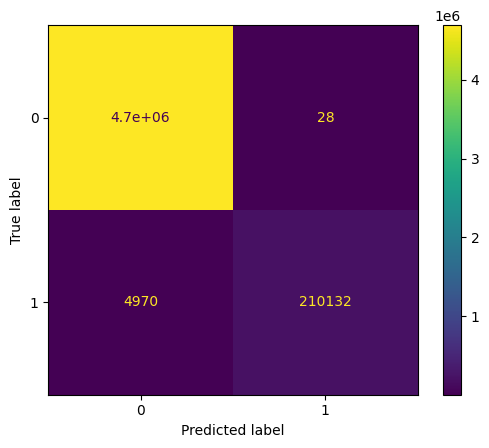

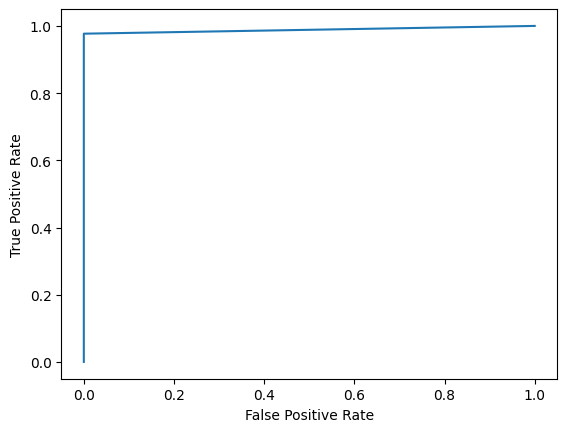

In [227]:
print('Grid Search')
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)
y_pred_gs = grid_search.predict(X_test)
print(
    f"""
    Accuracy: {accuracy_score(y_test, y_pred_gs)}
    Precision: {precision_score(y_test, y_pred_gs)}
    Recall: {recall_score(y_test, y_pred_gs)}
    F1-Score: {f1_score(y_test, y_pred_gs)}
    ROC AUC: {roc_auc_score(y_test, y_pred_gs)}\n
    """
)
conf_matrix = confusion_matrix(y_test, y_pred_gs)
cm_display = ConfusionMatrixDisplay(conf_matrix).plot()
fpr, tpr, _ = roc_curve(y_test, y_pred_gs)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [228]:
# Prediction for each attack
for i, att in enumerate(['DoS', 'Fuzzy', 'gear', 'RPM']):
    y_pred_att = grid_search.predict(model_data["X_test"][i])

    print(
        f"""
        {att}
        Accuracy: {accuracy_score(model_data["y_test"][i], y_pred_att)}
        Precision: {precision_score(model_data["y_test"][i], y_pred_att)}
        Recall: {recall_score(model_data["y_test"][i], y_pred_att)}
        F1-Score: {f1_score(model_data["y_test"][i], y_pred_att)}
        ROC AUC: {roc_auc_score(model_data["y_test"][i], y_pred_att)}\n
        """
    )


        DoS
        Accuracy: 1.0
        Precision: 1.0
        Recall: 1.0
        F1-Score: 1.0
        ROC AUC: 1.0

        

        Fuzzy
        Accuracy: 0.9955700938233689
        Precision: 0.9995926569628503
        Recall: 0.881040714234424
        F1-Score: 0.9365800287520832
        ROC AUC: 0.9405134352777008

        

        gear
        Accuracy: 0.9999901581658455
        Precision: 0.9998117306299783
        Recall: 1.0
        F1-Score: 0.999905856452816
        ROC AUC: 0.9999948077053653

        

        RPM
        Accuracy: 1.0
        Precision: 1.0
        Recall: 1.0
        F1-Score: 1.0
        ROC AUC: 1.0

        


Custom Grid Search

In [229]:
max_depths = [3, 5, 7, 9]
min_samples_split = [2, 4, 6]
min_samples_leaf = [1, 2, 3]
temp_grid = [{ "max_depth": md, "min_samples_split": mss } for mss in min_samples_split for md in max_depths]
params_grid = []
for msl in min_samples_leaf:
    for tg in temp_grid:
        pg = tg.copy()
        pg["min_samples_leaf"] = msl
        params_grid.append(pg)

for param_grid in params_grid:
    dtc = DecisionTreeClassifier(**param_grid)
    # start_time = datetime.now()
    dtc.fit(X_train, y_train)
    # end_time = datetime.now()
    # time_diff = end_time - start_time
    # print(f"Training time: {time_diff.total_seconds() / 60}")

    y_train_pred = dtc.predict(X_train)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mses.append(train_mse)
    
    for i, att in enumerate(['DoS', 'Fuzzy', 'gear', 'RPM']):
        # evaluate the accuracy on the validation set
        y_val_pred = dtc.predict(model_data["X_val"][i])
        val_mse = mean_squared_error(model_data["y_val"][i], y_val_pred)
        val_mses[att].append(val_mse)

        y_pred_att = dtc.predict(model_data["X_test"][i])


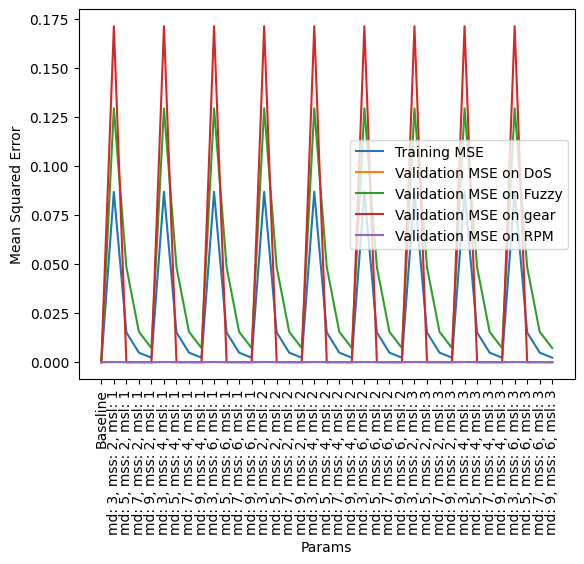

In [231]:
params = ["Baseline"]
temp = [f"md: {p['max_depth']}, mss: {p['min_samples_split']}, msl: {p['min_samples_leaf']}" for p in params_grid]
params.extend(temp)
# print(params)
plt.plot(params, train_mses, label='Training MSE')
for att in ['DoS', 'Fuzzy', 'gear', 'RPM']:
    plt.plot(params, val_mses[att], label=f'Validation MSE on {att}')
plt.xlabel('Params')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=90)
plt.legend()
plt.show()